# Trabajo Práctico N°1: FIUFIP
---
El siguiente informe es parte del trabajo grupal realizado para la materia de **Organización de Datos (75.06/95.58)** dictada en la **Facultad de Ingeniería de la Universidad 
de Buenos Aires (FIUBA)** durante el primer cuatrimestre del 2021.



Integrantes - Grupo 2:

Nombre | Padrón | Email
------ | ------| -------------
[BIANCARDI, Julian](https://github.com/JulianBiancardi) | 103945 | jbiancardi@fi.uba.ar
[HETREA, Joaquín Emanuel](https://github.com/JoaquinHetrea) | 103944 | jhetrea@fi.uba.a

---

# Enunciado

**Introducción:**

Una agencia gubernamental de recaudación de impuestos la FIUFIP nos a pedido que atrapemos a malechores que evaden impuestos y destruyen la economía.

Para ello la agencia desea entender la información que han estado recolectando de gente que paga los impuestos y quiere tener un sistema para el cual saber si una persona tiene altos ingresos o bajos ingresos a partir de los mismos.

Estos datos consisten en una serie de atributos de la persona que la agencia fue llenando y catalogando a la persona como de altos ingresos o no.

La agencia quiere utilizar la información recolectada para dirigir campañas de recaudación de impuestos y poder dirigir a los fiuagentes recaudadores a inspeccionar.

**Tarea:**

La primer tarea que nos piden es que presentemos un informe explicando qué conclusiones se pueden llegar a partir de analizar los datos recolectados. La agencia quiere saber cómo entender cada uno de los datos, cómo se relacionan entre sí y si se puede sacar alguna conclusión o descubrir un patrón a partir de estos. Adicionalmente quieren saber cuáles son los factores más importantes que determinan si un usuario tiene altos o bajos ingresos.

Si bien la agencia quiere empezar a usar técnicas avanzadas de predicción e inteligencia artificial, todavía tiene desconfianza en las mismas (personalmente comentaron que tienen miedo que las máquinas se revelen contra ellos) por lo que inicialmente no quieren nada complicado sino una serie muy simple de decisiones lógicas que les permitan en poco tiempo hacer una primera ronda de campaña digital. Se espera que este código simple (baseline) tenga una accuracy aceptable (mayor a 80%) y que esté basada y justificada en la investigación previa.

# Limpieza de datos

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter
import requests

In [ ]:
with requests.get(
    "https://docs.google.com/spreadsheets/d/1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0/export?format=csv"
) as r, open("impuestos.csv", "wb") as f:
    for chunk in r.iter_content():
        f.write(chunk)

Primero vemos el dataframe que se nos provee con la función **read_csv** : 

In [ ]:
df = pd.read_csv("impuestos.csv")
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


Vemos que con el comando **info()** tenemos la información completa del dataframe. Algunos features como por ejemplo: barrio, trabajo, etc tiene como tipo de dato *object* (default por el programa), por lo que deberemos cambiar estos tipos de datos.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   anios_estudiados                            32561 non-null  int64 
 1   barrio                                      31978 non-null  object
 2   categoria_de_trabajo                        30725 non-null  object
 3   edad                                        32561 non-null  int64 
 4   educacion_alcanzada                         32561 non-null  object
 5   estado_marital                              32561 non-null  object
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64 
 7   genero                                      32561 non-null  object
 8   horas_trabajo_registradas                   32561 non-null  int64 
 9   religion                                    32561 non-null  object
 10  rol_familiar_registrad

In [ ]:
(df.isnull().mean() * 100).to_frame('porcentaje nulls')

,porcentaje nulls
anios_estudiados,0.000000
barrio,1.790486
categoria_de_trabajo,5.638647
edad,0.000000
educacion_alcanzada,0.000000
estado_marital,0.000000
ganancia_perdida_declarada_bolsa_argentina,0.000000
genero,0.000000
horas_trabajo_registradas,0.000000
religion,0.000000


 Para este trabajo optamos por no eliminar las filas duplicadas ya que consideramos que seria información relevante para nuesto análisis exploratorio. Esto se debe a que no tenemos información que identifique una entrada de otra. Entonces el comando **drop_duplicates()** sería innecesario.

 Por otro lado, analizaremos si los features numéricos y nos aseguramos que no contengan valores inválidos. Por ejemplo, para la *edad* el valor no puede ser negativo y supusimos que aquellos mayores a 17 son considerados válidos. En el caso particular de *ganancia_perdida_declarada_bolsa_argentina* se admite número negativo ya que representa perdida. Vemos así que todos las columnas cuentan con información válida.

In [ ]:
df.describe()

,anios_estudiados,edad,ganancia_perdida_declarada_bolsa_argentina,horas_trabajo_registradas,tiene_alto_valor_adquisitivo
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456,0.240810
std,2.664488,13.640433,7408.986951,12.347429,0.427581
min,1.000000,17.000000,-4356.000000,1.000000,0.000000
25%,13.000000,28.000000,0.000000,40.000000,0.000000
50%,14.000000,37.000000,0.000000,40.000000,0.000000
75%,16.000000,48.000000,0.000000,45.000000,0.000000
max,20.000000,90.000000,99999.000000,99.000000,1.000000


La columna *barrio* contiene algunos valores en mayúscula y otros en minúscula, por lo que por comodidad pasaremos todo a un mismo formato. Por otro lado algunas filas no cuentan con información, decidimos agregar una nueva categoria llamada *otro*.

In [ ]:
df['barrio'] = df['barrio'].str.lower()
df['barrio'].replace({None: "otro"}, inplace=True)

Vemos que las columnas *Categoria de trabajo* y *Trabajo* tienen multiples valores nulls en las mismas filas:

In [ ]:
print("Cantidad de filas con 'categoria de trabajo' y 'trabajo' null: ", 
     ((df["categoria_de_trabajo"].isnull()) & (df["trabajo"].isnull())).sum())

Cantidad de filas con 'categoria de trabajo' y 'trabajo' null:  1836


Para la categoría de trabajo creamos una nueva opción llamada "no especificada", ya que consideramos que una persona que no completo este campo podría aun así pertenecer a una de las categorias indicadas.

Operamos de manera similar con la columna *trabajo*.

In [ ]:
df['categoria_de_trabajo'].replace({None: "no_especificada"}, inplace=True)
df['trabajo'].replace({None: "no_especificado"}, inplace=True)

La columna *rol_familiar_registrado* cuenta con las categorías casado y casada por separado. Decidimos juntarlas para asi tener menos categorías dentro de la misma.

In [ ]:
df['rol_familiar_registrado'].replace({"casado": "casado_a", "casada": "casado_a"}, inplace=True)

Algunas columnas como por ejemplo *categoria_de_trabajo* contienen algunos valores mal escritos. Procederemos a arreglarlos:

In [ ]:
df['categoria_de_trabajo'].replace({"monotibutista": "monotributista"}, inplace=True)
df['barrio'].replace({"cilla riachuelo": "villa riachuelo"}, inplace=True)

La columna *tiene_alto_valor_adquisitivo* es de tipo int64 cuando solo toma los valores 0 o 1, por lo que la cambiaremos a *bool* que consideramos más acorde.

In [ ]:
df['tiene_alto_valor_adquisitivo'] = df['tiene_alto_valor_adquisitivo'].astype(np.bool)

Vemos aquellas columnas con tipo *object* cuales son las que tienen un valor único. En nuestro caso ninguna de ellas, por lo que todas las columnas serán de tipo *category*.

In [ ]:
df.select_dtypes(include=['object']).nunique()

barrio                     42
categoria_de_trabajo        9
educacion_alcanzada        16
estado_marital              7
genero                      2
religion                    5
rol_familiar_registrado     5
trabajo                    15
dtype: int64

In [ ]:
df['barrio'] = df['barrio'].astype("category")
df['categoria_de_trabajo'] = df['categoria_de_trabajo'].astype("category")
df['educacion_alcanzada'] = df['educacion_alcanzada'].astype("category")
df['estado_marital'] = df['estado_marital'].astype("category")
df['genero'] = df['genero'].astype("category")
df['religion'] = df['religion'].astype("category")
df['rol_familiar_registrado'] = df['rol_familiar_registrado'].astype("category")
df['trabajo'] = df['trabajo'].astype("category")

El dataframe nos queda entonces de la siguiente manera:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   anios_estudiados                            32561 non-null  int64   
 1   barrio                                      32561 non-null  category
 2   categoria_de_trabajo                        32561 non-null  category
 3   edad                                        32561 non-null  int64   
 4   educacion_alcanzada                         32561 non-null  category
 5   estado_marital                              32561 non-null  category
 6   ganancia_perdida_declarada_bolsa_argentina  32561 non-null  int64   
 7   genero                                      32561 non-null  category
 8   horas_trabajo_registradas                   32561 non-null  int64   
 9   religion                                    32561 non-null  category
 10

# Análisis de datos

Para el análisis de los datos provistos decidimos realizar los siguientes pasos:


1.   Graficar las distribuciones de las distintas columnas para visualizar así con que estamos trabajando,
2.   Relacionar cada columna con la variable objetivo para obtener conclusiones,
3.   En base a las conclusiones obtenidas en el punto anterior, elegir aquella columna que consideramos que mejor estima la variable objetivo,
4.   Repetir el paso 3 hasta que la subdivisión ya no sea considerable

## Distribuciones de los datos

Arrancaremos graficando las distintas distribuciones de todas las columnas para ver con que datos nos encontramos:

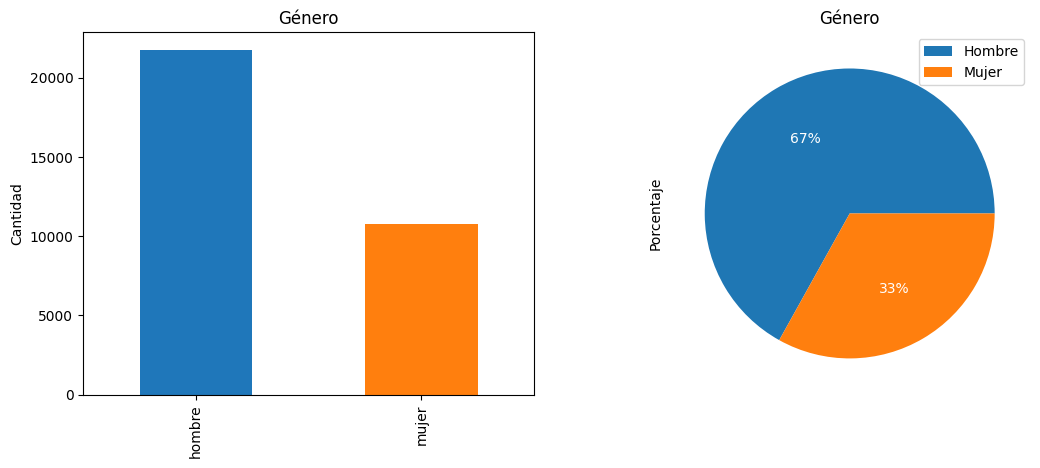

<Figure size 480x320 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df.genero.value_counts().plot(kind='bar', ax=axes[0], color=['#1f77ba', '#ff7f0e'])
axes[0].set_title("Género")
axes[0].set_ylabel("Cantidad")

plt.figure(dpi=80)
df["genero"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},ax=axes[1]
)
axes[1].legend(labels=['Hombre','Mujer'])
axes[1].set_title("Género")
axes[1].set_ylabel("Porcentaje")

plt.show()

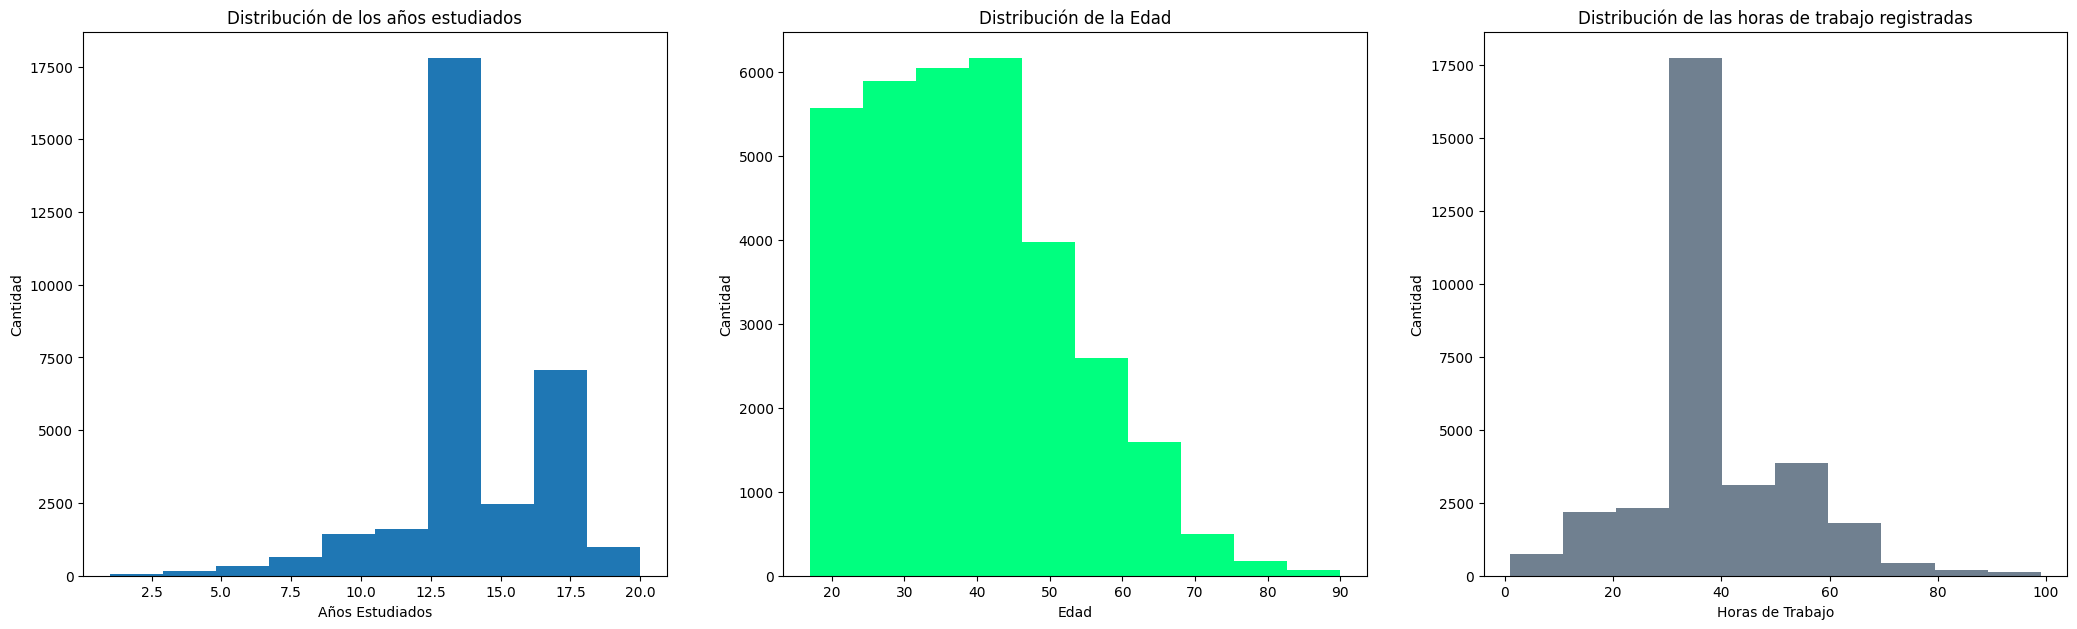

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[6.4 * 4, 4.8 * 1.5], dpi=100)

df.anios_estudiados.plot(kind='hist', ax=axes[0])
axes[0].set_title("Distribución de los años estudiados")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Años Estudiados")

df.edad.plot(kind='hist', ax=axes[1],color='springgreen')
axes[1].set_title("Distribución de la Edad")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")

df.horas_trabajo_registradas.plot(kind='hist', ax=axes[2],color='slategrey')
axes[2].set_title("Distribución de las horas de trabajo registradas")
axes[2].set_ylabel("Cantidad")
axes[2].set_xlabel("Horas de Trabajo")
plt.show()

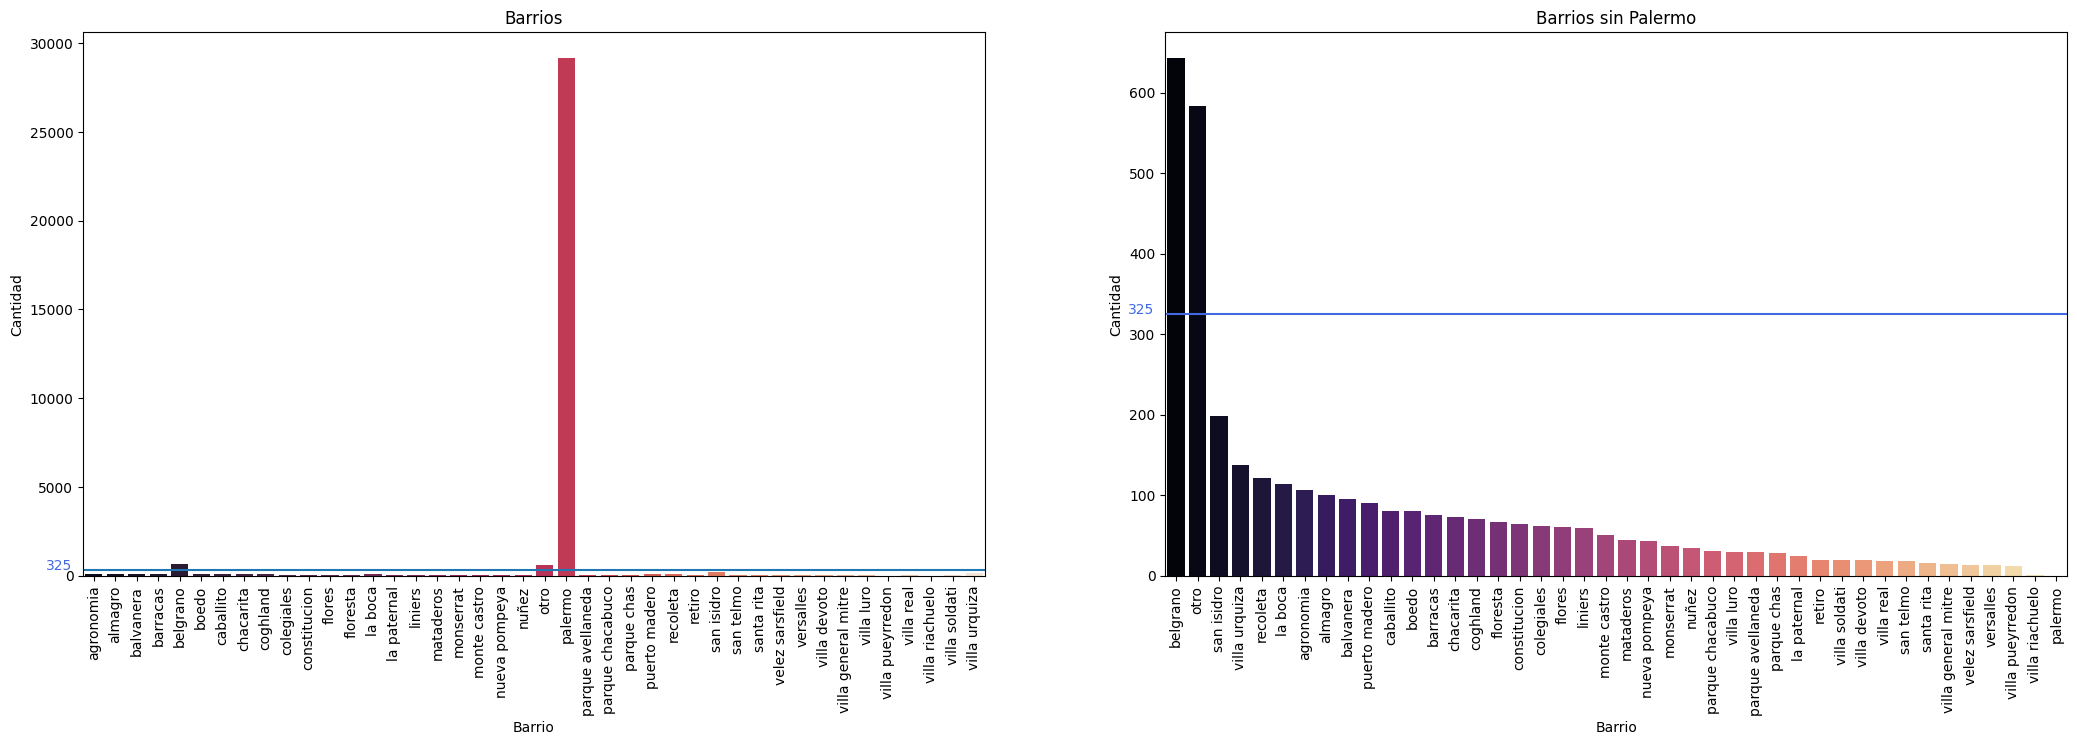

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 4, 4.8 * 1.5], dpi=100)

axes[0] = sns.countplot(x='barrio',data=df,palette='rocket', ax=axes[0])
axes[0].set_title("Barrios")
axes[0].set_xlabel("Barrio")
axes[0].set_ylabel("Cantidad")
axes[0].axhline(y = 325)
y = 325
axes[0].text(-2.25, y, '325', color="royalblue")


df_sin_palermo = df[df["barrio"] != "palermo"]
axes[1] = sns.countplot(x='barrio',data=df_sin_palermo,orient="h", order=(df_sin_palermo["barrio"]).value_counts().index,palette='magma', ax=axes[1])
axes[1].set_title("Barrios sin Palermo")
axes[1].set_xlabel("Barrio")
axes[1].set_ylabel("Cantidad")

plt.axhline(y=325, color="royalblue", label="1% aprox")
axes[1].text(-2.25, y, '325', color="royalblue")

plt.sca(axes[0])
plt.xticks(rotation=90)
plt.sca(axes[1])
plt.xticks(rotation=90)
plt.show()



Podemos ver que la gran mayoríaa de samples pertenecen al barrio *Palermo*. Ademas se ve que muchos de los barrios tienen una cantidad poco significativa. En ambos gráficos marcamos el 1% de la cantidad de datos, se ve solo dos barrios de los restantes superan este porcentaje del total de datos, de modo que se evidencia la poca información que nos proporcionan.

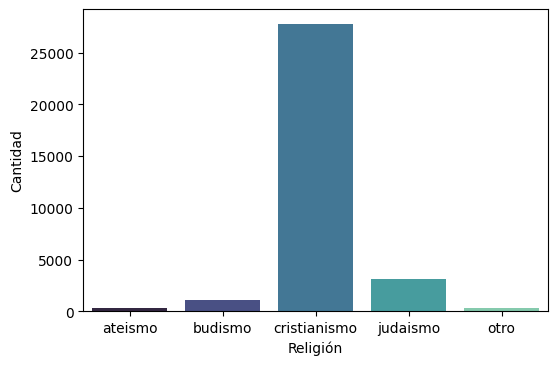

In [ ]:
plt.figure(dpi=100)
ax = sns.countplot(x='religion',data=df,palette='mako')
ax.set_xlabel("Religión")
ax.set_ylabel("Cantidad")
plt.show()

Similar a como ocurre con los barrios, el cristianismo supera en cantidad de datos ampliamente a las demas religiones. 

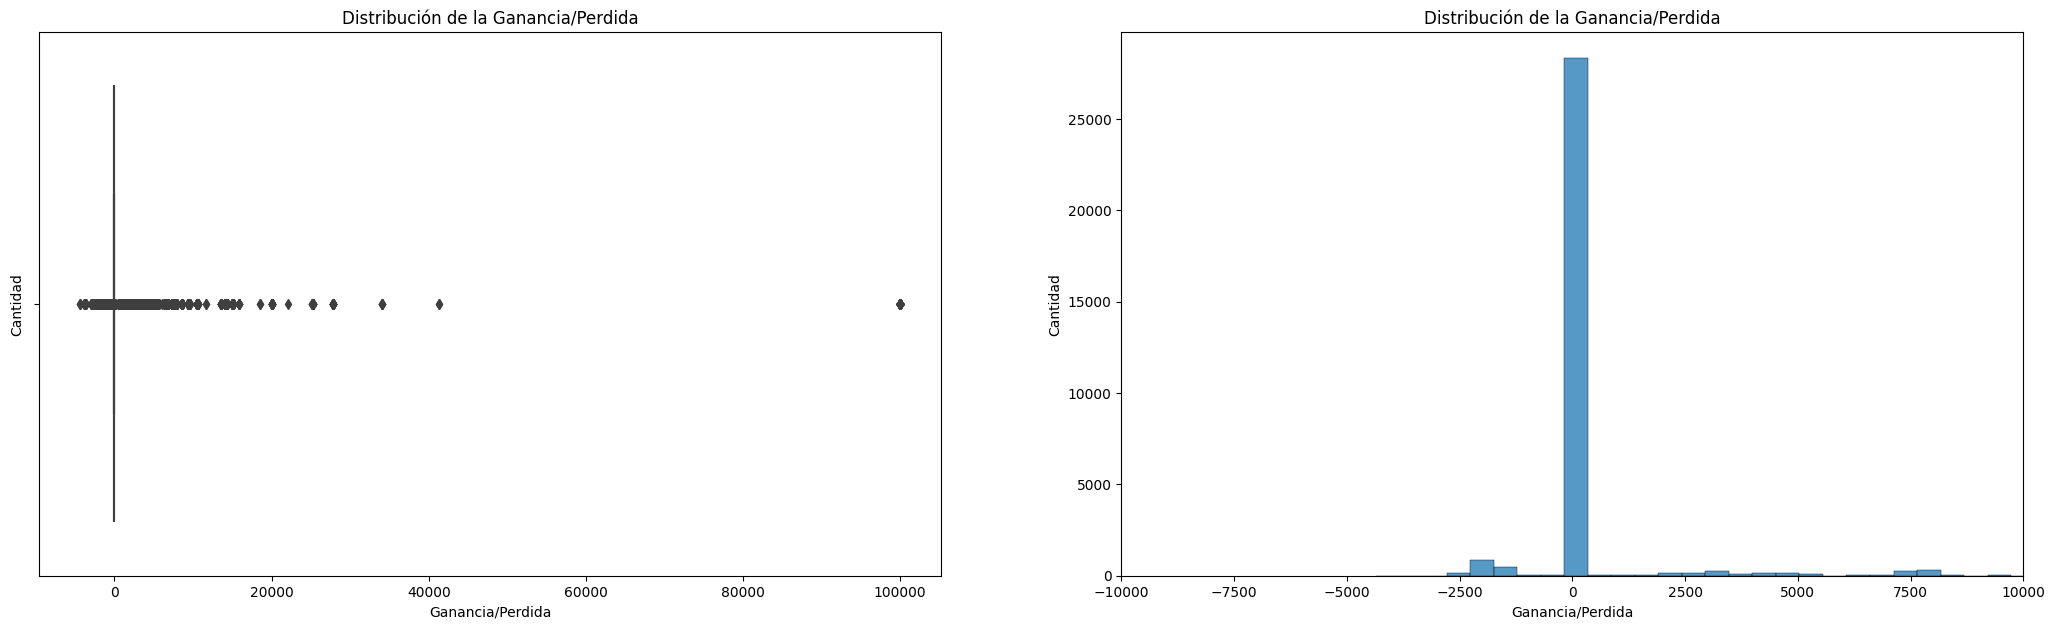

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 4, 4.8 * 1.5], dpi=100)

sns.boxplot(x='ganancia_perdida_declarada_bolsa_argentina',data=df, ax=axes[0])
axes[0].set_title("Distribución de la Ganancia/Perdida")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Ganancia/Perdida")

sns.histplot(x='ganancia_perdida_declarada_bolsa_argentina',data=df,bins=200, ax=axes[1])
axes[1].set_title("Distribución de la Ganancia/Perdida")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Ganancia/Perdida")
plt.xlim([-10000,10000])
plt.show()

De los gráficos anteriores podemos identificar que la mayor parte de los datos son de hombres, siguen al cristianismo, son de Palermo, tienen un rango de edad de entre 20 y 50 años, con una cantidad de entre 10 a 15 años estudiados y con balance neutro declarada en la bolsa argentina.

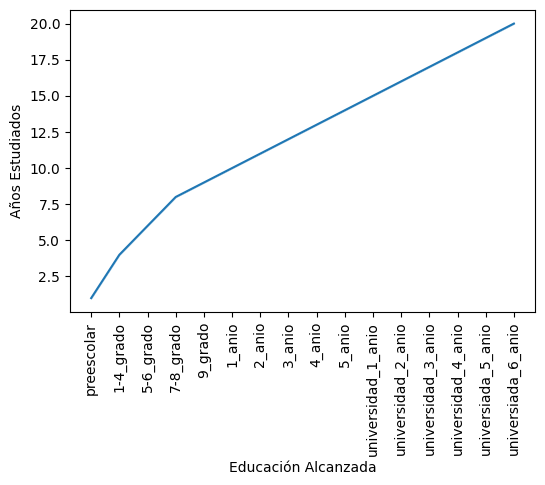

In [ ]:
df['educacion_alcanzada'] = pd.Categorical(df['educacion_alcanzada'], categories=[
    'preescolar', '1-4_grado', '5-6_grado',
    '7-8_grado', '9_grado', '1_anio',
    '2_anio', '3_anio', '4_anio',
    '5_anio', 'universidad_1_anio',
    'universidad_2_anio', 'universidad_3_anio',
    'universidad_4_anio', 'universiada_5_anio',
    'universiada_6_anio'
], ordered=True)

plt.figure(dpi=100)
ax = sns.lineplot(
    data=df, 
    x='educacion_alcanzada',
    y='anios_estudiados',
    sort = True,
)
ax.set_ylabel("Años Estudiados")
ax.set_xlabel("Educación Alcanzada")
plt.xticks(rotation=90)
plt.show()

Por otro lado, nos dimos cuenta que tanto la columna *anios_estudiados* y *educacion_alcanzada* se relacionaban linealmente. Decidimos eliminar la columna *educacion_alcanzada*.

In [ ]:
del(df['educacion_alcanzada'])

Veamos si hay alguna correlación lineal entre las columnas numéricas:

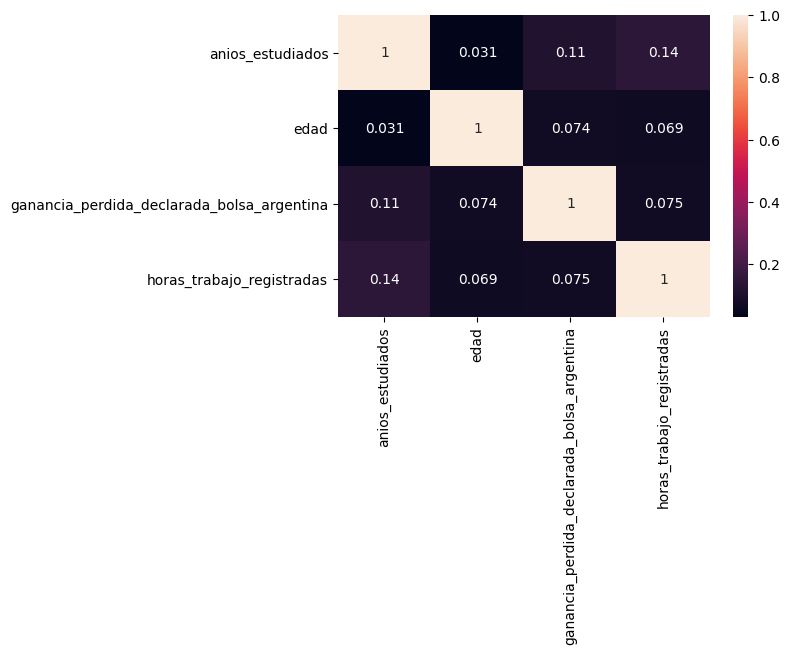

In [ ]:
df_correlation = df.drop(columns=['tiene_alto_valor_adquisitivo'])
plt.figure(dpi=100)
sns.heatmap(df_correlation.corr(), annot=True)
plt.show()

Por ultimo realizaremos un grafico que nos muestre la proporción de aquellas personas que tienen alto valor adquisitivo:

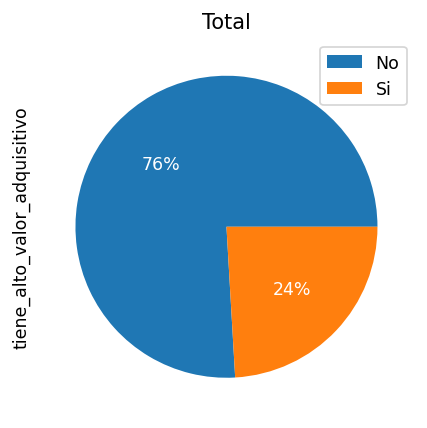

In [ ]:
plt.figure(dpi=125)
df["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"},
)
plt.legend(labels=['No','Si'])
plt.title("Total")
plt.show() 

Vemos que la mayoria de las personas entrevistadas no tienen alto valor adquisitivo. Nos basaremos en esta relacion para los siguientes analisis, para asi determinar si la información nos ayuda a llegar a una conclusión.

Entonces, conociendo las proporciones para saber si una persona tendrá alto valor adquisitivo, nos iremos preguntando si cada columna tiene una relación fuerte con la variable objetivo.

## ¿El genero de la persona nos podrá decir algo acerca si la persona tiene o no alto valor adquisitivo?

Si separamos por genero vemos que las mujeres tienen un mayor porcentajes de casos sin alto valor adquisitivo que los hombres. En el caso de los hombres la division es similar a la division general, por lo que no podemos sacar conclusiones.

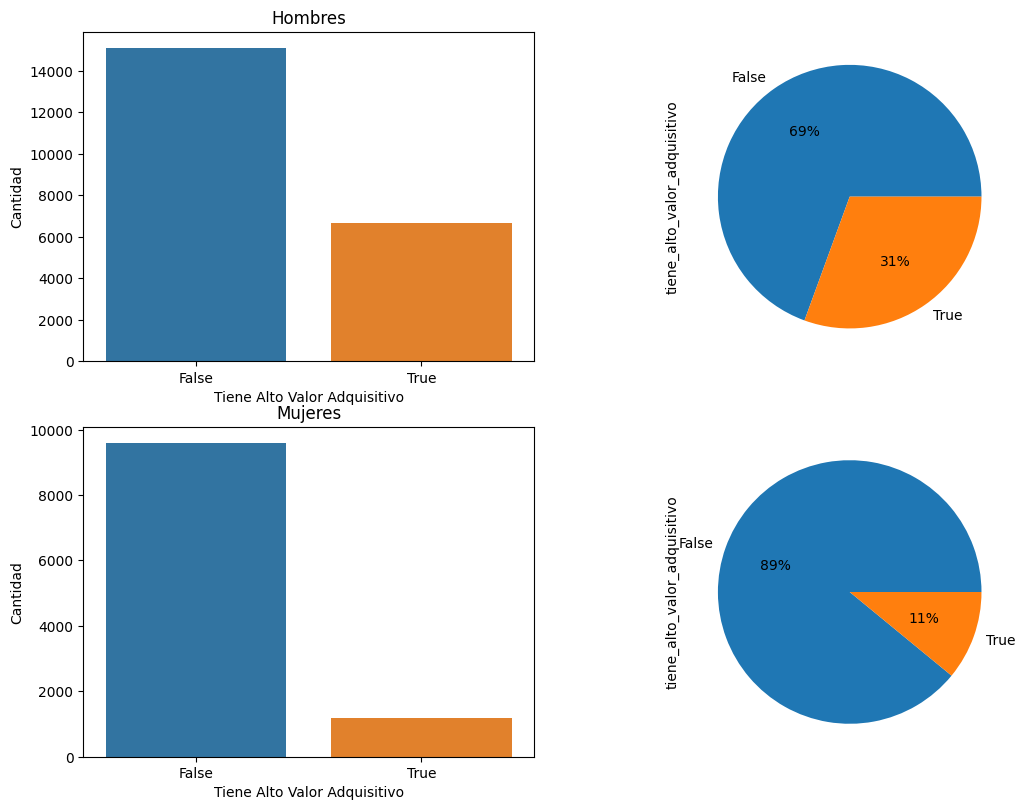

<Figure size 600x400 with 0 Axes>

<Figure size 600x400 with 0 Axes>

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[6.4 * 2, 4.8* 2], dpi=100)

df_men = df[df['genero'] == 'hombre']
df_women = df[df['genero'] == 'mujer']

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_men,ax=axes[0][0])
axes[0][0].set_title("Hombres")
axes[0][0].set_ylabel("Cantidad")
axes[0][0].set_xlabel("Tiene Alto Valor Adquisitivo")

plt.figure(dpi=100)
df_men["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[0][1]
)

sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_women,ax=axes[1][0])
axes[1][0].set_title("Mujeres")
axes[1][0].set_ylabel("Cantidad")
axes[1][0].set_xlabel("Tiene Alto Valor Adquisitivo")

plt.figure(dpi=100)
df_women["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%',ax=axes[1][1]
)

plt.show()

Por lo que llegamos a nuestra primera conclusión: 
 - **El 89% de las mujeres entrevistadas NO tienen alto valor adquisitivo**

Pasemos ahora a nuestra segunda pregunta

## ¿Que relación hay entre el balance de la ganancia/perdida en la bolsa argentina y el alto valor adquisitivo?

Para hacer este análisis primero vamos a separar los valores posibles en tres categorias: 
1.   Negativo: aquellos que tienen perdidas declaradas
2.   Positivo: aquellos que tienen ganancias declaradas
3.   Neutro: aquellos que no declaran ni ganancia ni perdida


In [ ]:
def balance(bolsa):
    if (bolsa > 0):
        return "Positivo"
    elif bolsa < 0:
        return "Negativo"
    else:
        return "Neutro"

df['balance'] = df["ganancia_perdida_declarada_bolsa_argentina"].apply(balance)

Una vez separado estos rangos de valores, veamos si alguno de estos tiene relación con el valor adquisitivo:

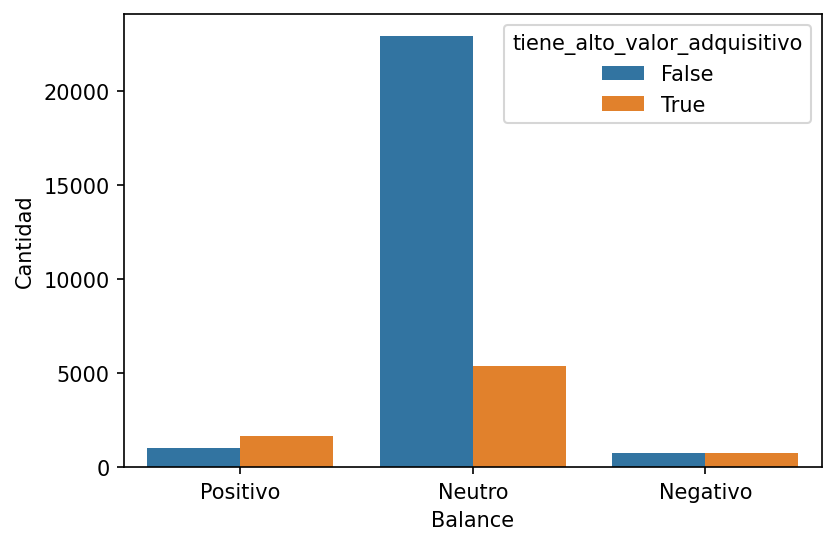

In [ ]:
plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df,hue='tiene_alto_valor_adquisitivo')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")
plt.show()

En el siguiente grafico vemos que aquellos con balance neutro suelen no tener alto valor adquisitivo. En los demas casos, la division tiende a ser equitativa, y por lo tanto no nos aporta demasiada información. Además, estas divisiones estan basadas en una cantidad de casos significativamente menor que el caso de balance neutro.

In [ ]:
total = len(df[(df['balance'] == 'Neutro')])
cantidad = len(df[(df['balance'] == 'Neutro') & (df['tiene_alto_valor_adquisitivo'] == False)])
porcentaje = (cantidad / total) * 100
print(cantidad, "personas tienen balance neutro. Aproximadamente un",porcentaje,"% del total.")

22939 personas tienen balance neutro. Aproximadamente un 80.97070243558065 % del total.


Por lo que llegamos asi a nuestra segunda conclusión: 
  - **El 81% de las personas con balance neutro NO tienen alto valor adquisitivo**

 (No es tan fuerte como la anterior pero consideramos que es relevante)

## ¿La ganancia/perdida en la bolsa argentina influye al valor adquisitivo?

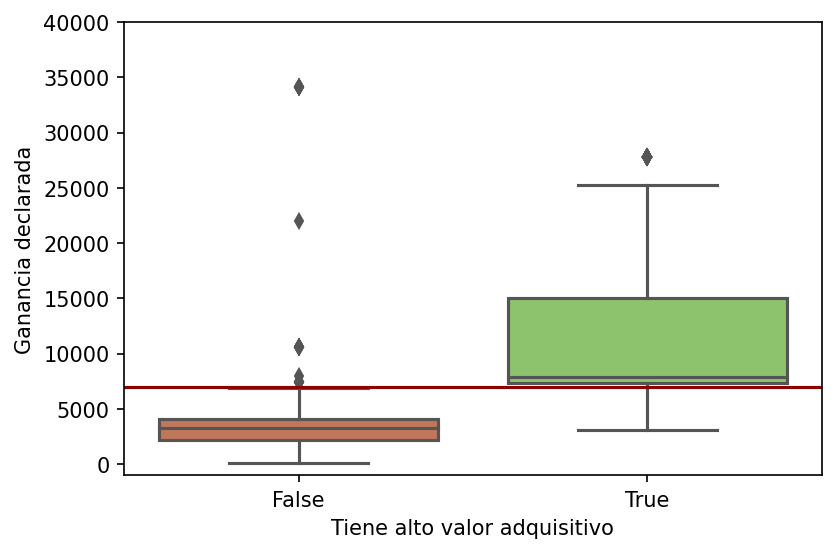

In [ ]:
plt.figure(dpi=150)
df_aux2 = df[(df["ganancia_perdida_declarada_bolsa_argentina"] > 0)]
ax = sns.boxplot(
    data=df_aux2,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"],
)
ax.set_xlabel("Tiene alto valor adquisitivo")
ax.set_ylabel("Ganancia declarada")
plt.axhline(y=7000, color="darkred")
plt.ylim([-1000, 40000])
plt.show()

Podemos ver claramente que quienes tienen alto valor adquisitivo tienden a tener mayor ganancias registradas en caso de tener balance positivo.

## ¿Que relación tienen los años estudiados con el alto valor adquistivo?

Veamos cual es la proporción de personas con alto valor adquistivo con respecto a los años estudiados:

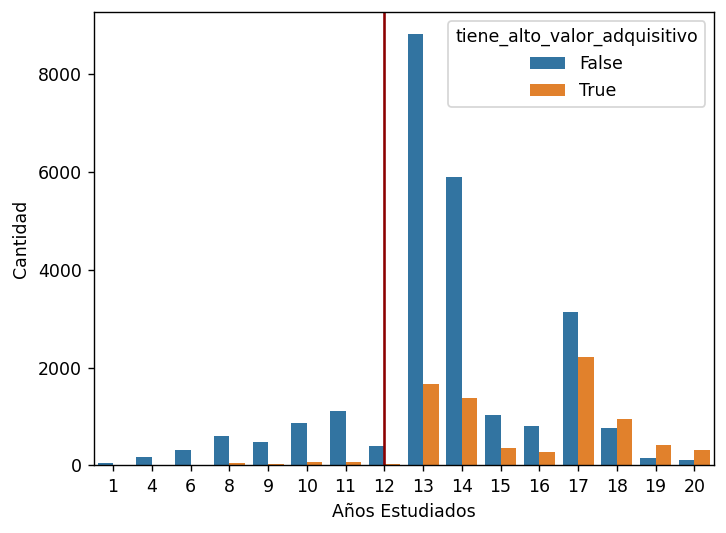

In [ ]:
plt.figure(figsize=(6.4, 4.8), dpi=125)
ax = sns.countplot(x='anios_estudiados',data=df,hue='tiene_alto_valor_adquisitivo')
plt.axvline(x=7, color="darkred")
ax.set_ylabel("Cantidad")
ax.set_xlabel("Años Estudiados")
plt.show()

Del siguiente gráfico diferenciamos dos zonas esenciales. Por un lado aquellas que tienen menos de 12 años estudiados tienden a no tener alto valor adquisitivo. Esto último se ve claramente debido a que por cada cantidad de año estudiado las proporciones de no tener alto valor adquisitivo son mayores considerablemente.

Por otro lado a medida que aumenta la cantidad de años estudiados tambien lo hace la proporción de personas con alto valor adquisitivo.

Veamos la cantidad de gente que tiene menos de 12 años estudiados:

In [ ]:
total = len(df)
cantidad = len(df[df['anios_estudiados'] <= 12])
porcentaje = (cantidad / total) * 100
print(cantidad, "personas estudiaron menos de 12 años inclusive. Aproximadamente un",porcentaje,"% del total.")

4253 personas estudiaron menos de 12 años inclusive. Aproximadamente un 13.061638156076288 % del total.


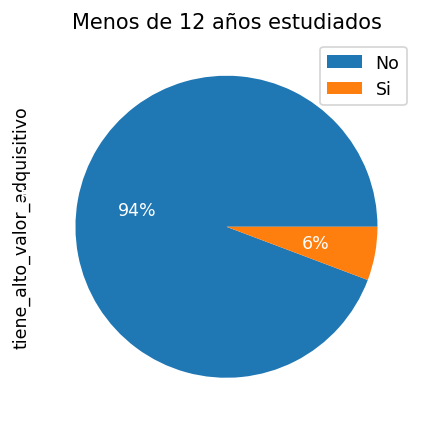

In [ ]:
plt.figure(dpi=125)
df_menos_12 = df[df['anios_estudiados'] <= 12]
df_menos_12["tiene_alto_valor_adquisitivo"].value_counts().plot(
    kind='pie', autopct='%1.0f%%', textprops={'color':"w"}
)
plt.legend(labels=['No','Si'])
plt.title("Menos de 12 años estudiados")
plt.show() 

A pesar de que las proporciones son muy favorables a decir que no tiene valor adquistivo hay que tener en cuenta que esta información es acerca del 13% del total de los datos. Por lo que la siguiente conclusión resulta ser debil con respecto a las anteriores:

- **El 94% de las personas que estudiaron menos de 13 años NO tienen alto valor adquisitivo.**

## ¿Que relación tienen la religión de la persona con el valor adquistivo?

Hagamos unos cálculos rápidos para determinar si la religión influye o no. Calculamos para cada religión el porcentaje de personas con alto valor adquistivo y sin alto valor adquisitivo. Adicionalmente vemos que proporción del total representa dicha religión para saber si la información resulta ser relevante para el analisis.

In [ ]:
def si(x):
    return (x == True).mean() * 100.0
def no(x):
    return (x == False).mean() * 100.0
def perc_total(x):
    return (x.count() / len(df)) * 100.0

df[['religion','tiene_alto_valor_adquisitivo']].groupby("religion").agg(
    {
        'tiene_alto_valor_adquisitivo': [si,no,perc_total],
    }
)

tiene_alto_valor_adquisitivo                      
                                       si         no perc_total
religion                                                       
ateismo                         11.575563  88.424437   0.955130
budismo                         26.564004  73.435996   3.190934
cristianismo                    25.585994  74.414006  85.427352
judaismo                        12.387964  87.612036   9.594300
otro                             9.225092  90.774908   0.832284

Vemos que la mayor parte de las personas entrevistadas son cristianas. Ahora recordemos el primer grafico que nos mostraba las propocion de gente con y sin valor adquisitivo, las proporciones del cristianismo son similares, entonces a pesar de ser la mayor parte no nos proporciona nueva información.

Por otra parte vemos que el 87.6% de las personas que son judias no tienen alto valor adquisitivo. Esta conclusion es debil como la anterior debido a que el porcentaje de personas es demasiado bajo como para generar relevancia.
  - **Si la persona sigue al judaismo, estamos un 87,6% seguros que NO tendrá valor adquisitivo.**

## ¿El barrio puede tener alguna relación con el valor adquistivo?

Considerando que la mayor parte de la gente entrevistada es del barrio *Palermo*, vemos la proporsion de personas con alto valor adquisitivo en este barrio:

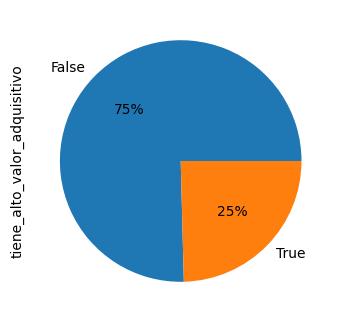

In [ ]:
plt.figure(dpi=100)
df_palermo = df[df['barrio'] == "palermo"]
df_palermo['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.show()

Esta información no nos aporta demasiado debido a que las proporciones son similares a la distribución general de la variable que queremos estimar.

Por lo que concluimos que:
*   **El barrio no será relevante a la hora de estimar si una persona tiene o no alto valor adquisitivo.**


## ¿El estado marital nos podrá decir algo?

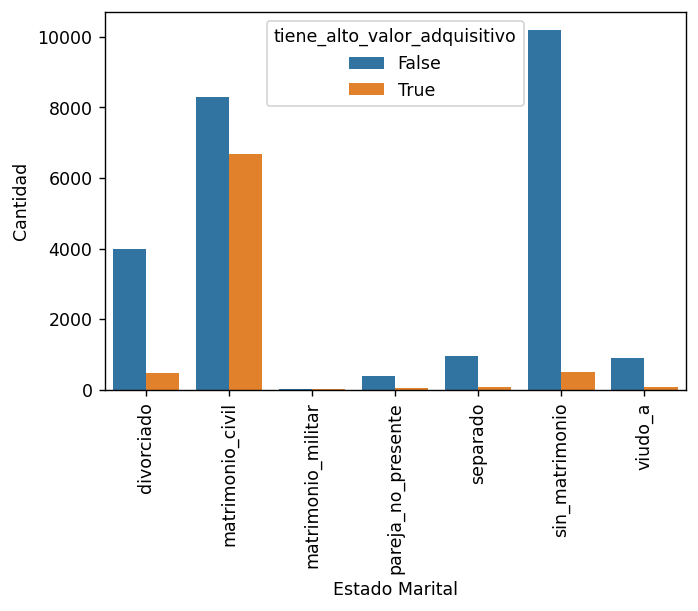

In [ ]:
plt.figure(dpi=125)
ax = sns.countplot(x='estado_marital',data=df,hue='tiene_alto_valor_adquisitivo')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Estado Marital")
plt.xticks(rotation=90)
plt.show()

Del siguiente grafico vemos que si el estado marital de la persona entrevistada no es *matrimonio_civil*, la probabilidad de que no tenga alto valor adquisitivo son altas. Veamos cuanta gente cumple con esta condición:

In [ ]:
total = len(df)
cantidad_sin_matromonio_civil = len(df[df['estado_marital'] != "matrimonio_civil"])
porcentaje = (cantidad_sin_matromonio_civil / total) * 100
print("Unas",cantidad_sin_matromonio_civil,"no estan casadas. Esto representa el",porcentaje,"% del total de entrevistados.")

Unas 17585 no estan casadas. Esto representa el 54.00632658702128 % del total de entrevistados.


Estos valores son muy relevantes debido a que la mitad de las personas cumplen esta condición y ademas tienen altas probabilidades de no tener alto valor adquisitivo:

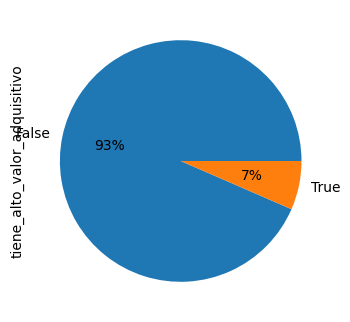

In [ ]:
plt.figure(dpi=100)
df_sin_matrimonio_civil = df[df['estado_marital'] != "matrimonio_civil"]
df_sin_matrimonio_civil['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.show()

Concluimos que: 
- **El 93% de las personas con estado marital distinto a *matrimonio_civil* no tienen alto valor adquisitivo.**
 
 (Esta conclusión resulta ser la mas fuerte hasta ahora y es la que usaremos inicialmente para predecir la variable objetivo)

## ¿Y que pasa con la edad de la persona?

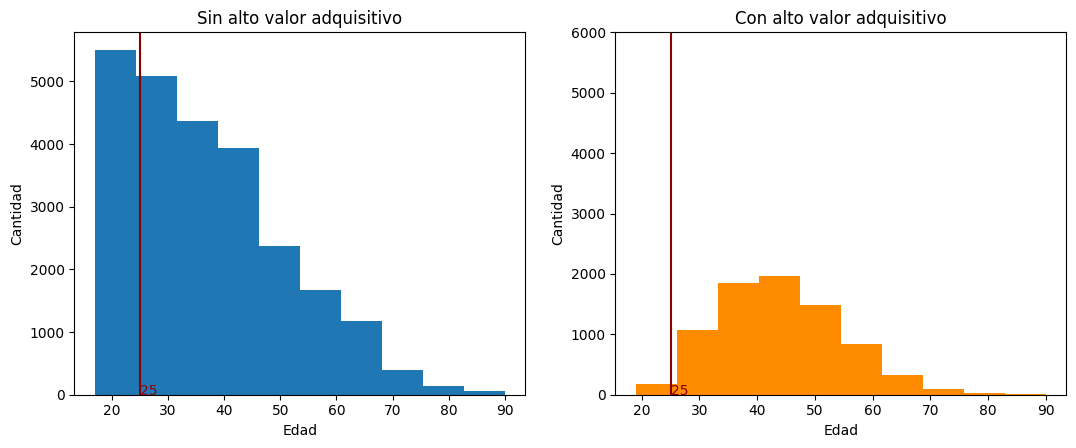

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_nva = df[df.tiene_alto_valor_adquisitivo == False]
df_va = df[df.tiene_alto_valor_adquisitivo == True]
x = 25

df_nva.edad.plot(kind='hist', ax=axes[0])
axes[0].set_title("Sin alto valor adquisitivo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Edad")
axes[0].axvline(x, color="darkred")
axes[0].text(x, .5, '25', color="darkred")

df_va.edad.plot(kind='hist',color='darkorange', ax=axes[1])
axes[1].set_title("Con alto valor adquisitivo")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")
axes[1].axvline(x, color="darkred")
axes[1].text(x, .5, '25', color="darkred")

plt.ylim([0, 6000])
plt.show()

Vemos que a partir de los graficos podemos identificar que las personas menores de 25 años tienden a no tener alto valor adquisitivo.

## ¿Aquellas personas que tienen mayor cantidad de horas de trabajo registradas tienden a tener alto valor adquisitivo?

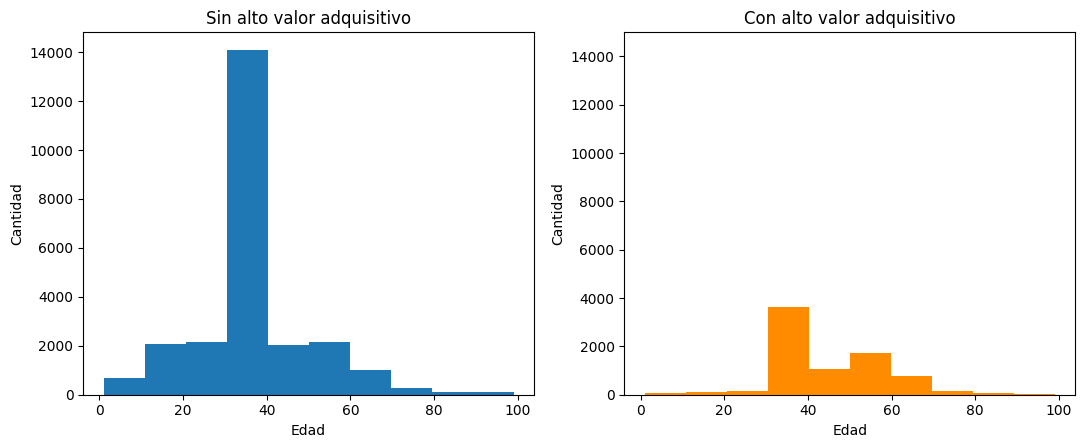

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_nva = df[df.tiene_alto_valor_adquisitivo == False]
df_va = df[df.tiene_alto_valor_adquisitivo == True]

df_nva.horas_trabajo_registradas.plot(kind='hist', ax=axes[0])
axes[0].set_title("Sin alto valor adquisitivo")
axes[0].set_ylabel("Cantidad")
axes[0].set_xlabel("Edad")

df_va.horas_trabajo_registradas.plot(kind='hist',color='darkorange', ax=axes[1])
axes[1].set_title("Con alto valor adquisitivo")
axes[1].set_ylabel("Cantidad")
axes[1].set_xlabel("Edad")

plt.ylim([0, 15000])
plt.show()

Las distribuciones parecen cumplir la distribución general, por lo tanto no podemos sacar una fuerte conclusión de estos gráficos.

## ¿La categoria de trabajo y/o el trabajo nos revelan algo acerca del valor adquisitivo?

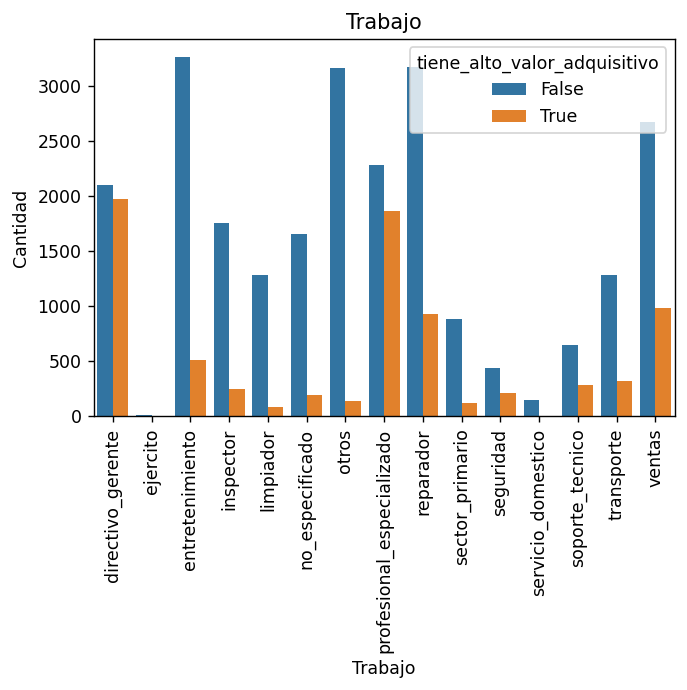

In [ ]:
plt.figure(dpi=125)
ax = sns.countplot(data=df, x='trabajo', hue='tiene_alto_valor_adquisitivo')
plt.title("Trabajo")
ax.set_ylabel("Cantidad")
ax.set_xlabel("Trabajo")
plt.xticks(rotation=90)
plt.show()

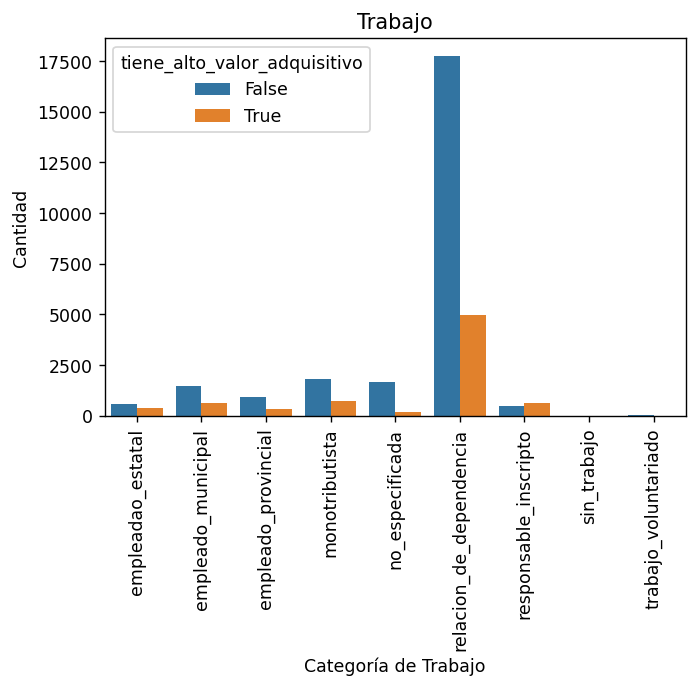

In [ ]:
plt.figure(dpi=125)
ax = sns.countplot(data=df, x='categoria_de_trabajo', hue='tiene_alto_valor_adquisitivo')
plt.title("Trabajo")
ax.set_ylabel("Cantidad")
ax.set_xlabel("Categoría de Trabajo")
plt.xticks(rotation=90)
plt.show()

En ambos casos vemos que la mayoria de las opciones respetan la distribución general. Solo unas pocas rompen esta regla, por lo que la conclusion sería debil ya que estaría basada en una categoría específica y además en una cantidad reducida de datos.

## ¿Y que ocurre con el rol familiar registrado?

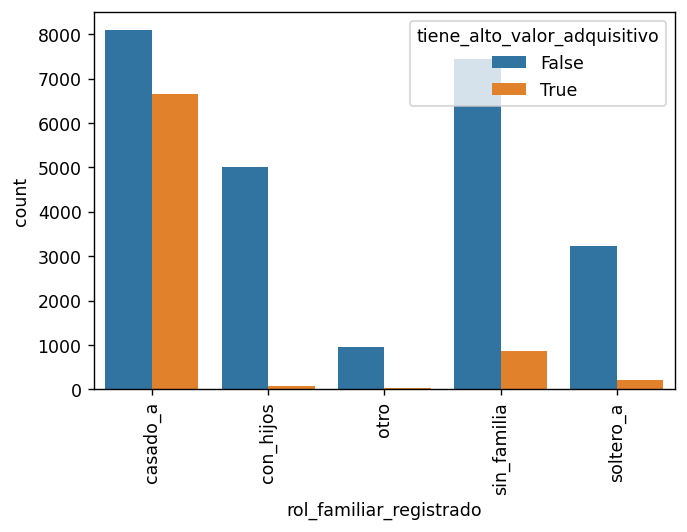

In [ ]:
plt.figure(dpi=125)
sns.countplot(data=df, x='rol_familiar_registrado', hue='tiene_alto_valor_adquisitivo')
plt.xticks(rotation=90)
plt.show()

A partir del grafico vemos que si la persona no esta casada, es muy probable que no tenga alto valor adquisitivo. 

In [ ]:
total = len(df)
cantidad_no_casada = len(df[df['rol_familiar_registrado'] != "casado_a"])
porcentaje = (cantidad_no_casada / total) * 100
print("Unas",cantidad_no_casada,"no estan casadas. Esto representa el",porcentaje,"% del total de entrevistados.")

Unas 17800 no estan casadas. Esto representa el 54.666625717883356 % del total de entrevistados.


Nuevamente, estos valores son muy relevantes, similar al caso del estado marital, aunque con una menor cantidad de datos.

# Relaciones

Una vez analizado las distintas columnas con nuestra variable objetivo (ver si una persona tiene o no alto valor adquisitivo) llegamos a las distintas conclusiones que se muestran a continuación:

*   El estado marital de la persona es muy relevante en el valor adquisitivo. Si el mismo no es *matrimonio_civil*, tiende a no tener alto valor adquisitivo
*   El rol familiar registrado tambien es muy relevante en cuanto al valor adquisitivo, aunque menos que el estado marital.
*   Si la persona es mujer, tiende a no tener alto valor adquisitivo
*   Si la persona tiene balance neutro, tiende a no tener alto valor adquisitivo
*   Si la persona tiene un balance muy positivo, tiende a tener alto valor adquisitivo
*   Si la persona estudió menos de 12 años, tiende a no tener alto valor adquisitivo
*   Si la perosna sigue el judaismo, tiende a no tener alto valor adquisitivo
*   Si la persona es menor de 25 años, tiende a no tener alto valor adquisitivo
*   Tanto el trabajo como la categoria de trabajo no nos aportan información relevante
*   Por ultimo, el barrio tampoco nos dice si la persona tiene o no alto valor adquisitivo

Procederemos a elegir la que consideramos que divida más a la muestra. En nuestro caso decidimos que el **estado marital** de la persona divide considerablemente si no es **matrimonio_civil**.

Inicialmente sabemos que si el estado marital de la persona es *matrimonio_civil* podemos decir que no tendrá alto valor adquisitivo, pero ¿que pasa en el otro caso?. Comenzaremos estudiando este caso

In [ ]:
df_mc = df[df['estado_marital'] == "matrimonio_civil"]

Veamos cuantos son los que tienen alto valor adquisitivo:

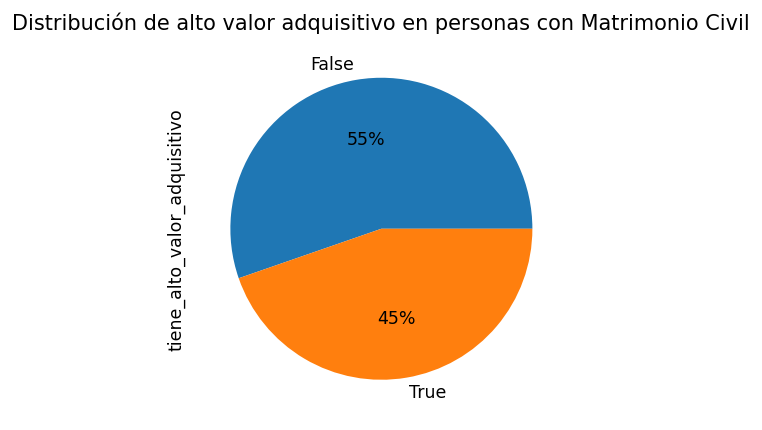

In [ ]:
plt.figure(dpi=125)
df_mc['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.title("Distribución de alto valor adquisitivo en personas con Matrimonio Civil")
plt.show()

La división resulta equitativa para ambas partes, por lo que intentaremos buscar alguna otra columna que separe considerablemente para poder llegar a una nueva conclusión.


**NOTA:** Si bien analizamos todas las posibles combinaciónes de columnas con *Matrimonio Civil*, decidimos exponer en este trabajo aquellas que consideramos que nos aportaban informacion relevante.

## Matrimonio Civil vs Balance

Veamos si existe alguna relación entre el matrimonio civil y el balance de la persona (recordemos que el balance puede ser: Negativo, Neutro o Positivo):

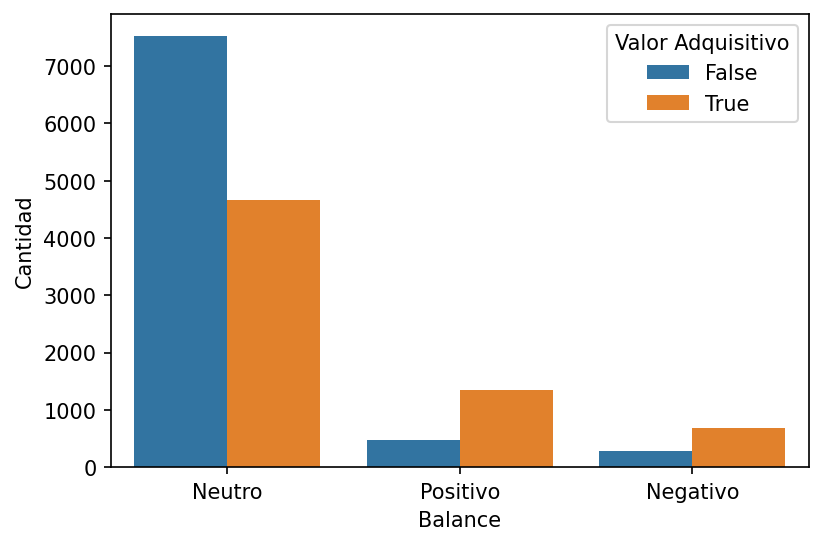

In [ ]:
plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df_mc,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='Valor Adquisitivo', loc='upper right')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


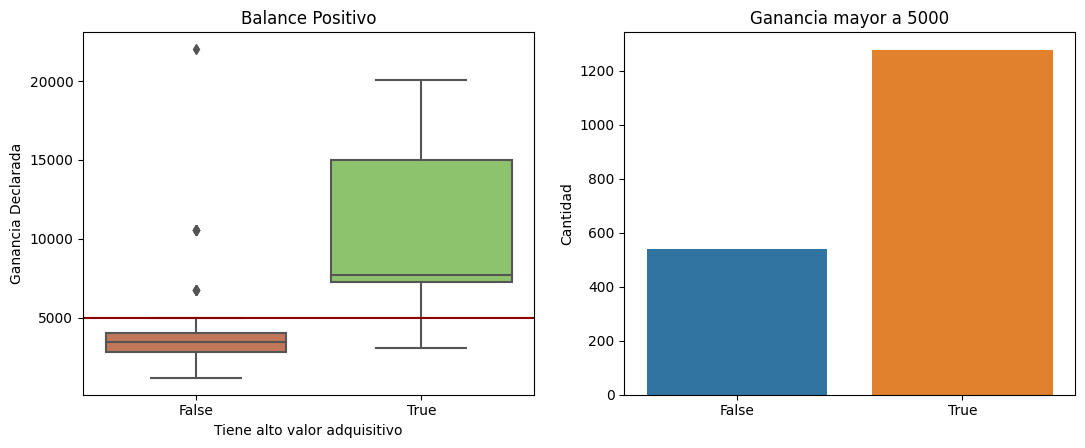

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_aux = df_mc[(df_mc["ganancia_perdida_declarada_bolsa_argentina"] > 0) & (df_mc["ganancia_perdida_declarada_bolsa_argentina"] < 40000)]
sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"],
    ax=axes[0]
)
axes[0].set_title("Balance Positivo")
axes[0].set_xlabel("Tiene alto valor adquisitivo")
axes[0].set_ylabel("Ganancia Declarada")
axes[0].axhline(y=5000, color="darkred")


df_aux2['muy_positivo'] = df_mc['ganancia_perdida_declarada_bolsa_argentina'] > 5000
sns.countplot(x='muy_positivo',data=df_aux2,ax=axes[1])
axes[1].set_title("Ganancia mayor a 5000")
axes[1].set_xlabel("")
axes[1].set_ylabel("Cantidad")

plt.show()

Nuevamente vemos que las personas con alto valor adquisitivo suelen tener mayores ganancias registradas que las que no tienen alto valor adquisitivo.

## Matrimonio civil vs Años estudiados



Veamos como se relacionan con los años estudiados:

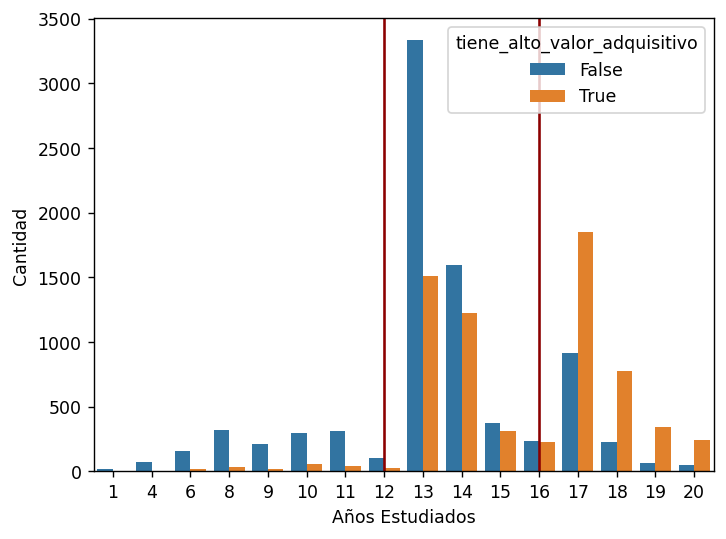

In [ ]:
plt.figure(figsize=(6.4, 4.8),dpi=125)
ax = sns.countplot(x='anios_estudiados',data=df_mc,hue='tiene_alto_valor_adquisitivo')
ax.set_ylabel("Cantidad")
ax.set_xlabel("Años Estudiados")
plt.axvline(x=7, color="darkred")
plt.axvline(x=11, color="darkred")
plt.show()

Observamos que es similar a la distribución de los años estudiados general. Nuevamente tenemos dos zonas esenciales:

-   Aquellos con mas de 16 años estudiados tienden a tener alto valor adquisitivo
-   Aquellos con menos de 13 años estudiados tienden a no tener alto valor adquisitivo

Veamos para cada zona cuanto divide a la muestra y si es considerable para llegar a una conclusión:



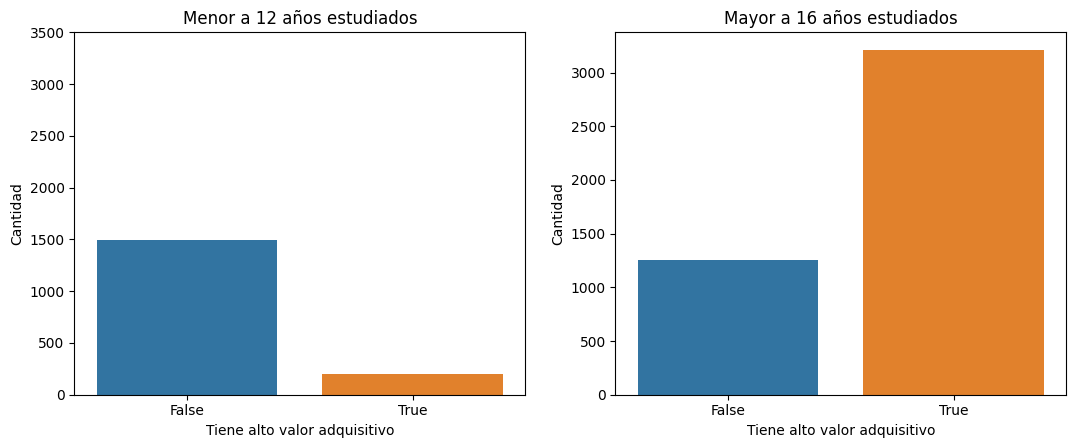

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[6.4 * 2, 4.8], dpi=100)

df_mc_sec = df_mc[df_mc['anios_estudiados'] <= 12]
df_mc_uni = df_mc[df_mc['anios_estudiados'] > 16]

ax0 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_sec,ax=axes[0])
ax0.set_title("Menor a 12 años estudiados")
ax0.set_ylabel("Cantidad")
ax0.set_xlabel("Tiene alto valor adquisitivo")
ax0.set_ylim([0, 3500])

ax1 = sns.countplot(x='tiene_alto_valor_adquisitivo',data=df_mc_uni,ax=axes[1])
ax1.set_title("Mayor a 16 años estudiados")
ax1.set_ylabel("Cantidad")
ax1.set_xlabel("Tiene alto valor adquisitivo")


plt.show()

Vemos que para aquellos con menos de 13 años estudiados las proporciones se diferencian significativamente, pero la cantidad de casos es mayor para aquellos con mas de 16 años estudiados. Entonces debemos tomar una decisión en cual elegir y que consideremos que será relevante para la predicción de la variable objetivo. Optamos por quedarnos con:

*    Aquellos con mas de 16 años estudiados tienden a tener alto valor adquisitivo

(Esta conclusión resulta ser mas fuerte que la del balance puesto que hay mas casos)

Ahora debemos observar el otro caso, las personas que estan casadas civilmente pero no tienen mas de 16 años estudiados, y ver como podemos subdividirlas.

### Menos de 16 años estudiados

Como la mayoria de las personas que nos queda no tienen alto valor adquisitivo (esta será nuestra estimación final), debemos buscar alguna división fuerte que estime que la persona tendrá alto valor adquisitivo.

Provemos nuevamente con el balance:

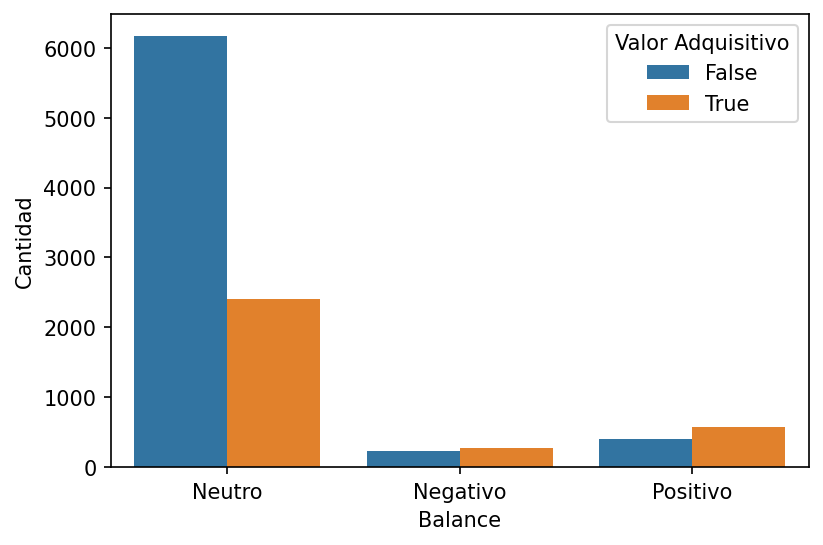

In [ ]:
df_mc_16 = df_mc[df_mc['anios_estudiados'] < 16]

plt.figure(dpi=150)
ax = sns.countplot(x='balance',data=df_mc_16,hue='tiene_alto_valor_adquisitivo')
ax.legend(title='Valor Adquisitivo', loc='upper right')
ax.set_xlabel("Balance")
ax.set_ylabel("Cantidad")
plt.show()

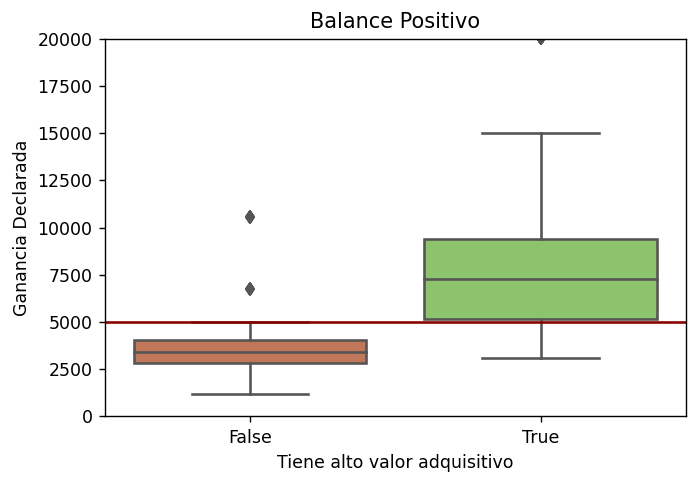

In [ ]:
plt.figure(dpi=125)
df_aux = df_mc_16[(df_mc_16["ganancia_perdida_declarada_bolsa_argentina"] > 0)]
ax0 = sns.boxplot(
    data=df_aux,
    y='ganancia_perdida_declarada_bolsa_argentina',
    x='tiene_alto_valor_adquisitivo',
    palette=['#D17049', "#89D15E"]
)
ax0.set_ylim([0,20000])
ax0.set_title("Balance Positivo")
ax0.set_xlabel("Tiene alto valor adquisitivo")
ax0.set_ylabel("Ganancia Declarada")
ax0.axhline(y=5000,color="darkred")
plt.show()


La ganancia igual a **5000** muestra ser el valor adecuado para dividir la muestra. Entonces:


*  **Aquellas personas con ganancia igual o mayor a 5000 tienden a tener alto valor adquistivo**

Como dijimos al principio de esta sección, las personas que nos restan estimaremos que no tendrán alto valora adquisitivo. Veamos que tan buena resulta esta estimación:

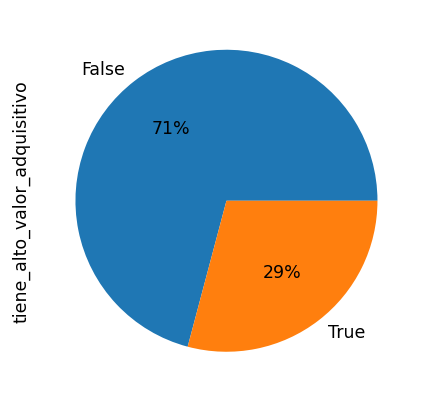

In [ ]:
plt.figure(dpi=125)
df_aux = df_mc_16[df_mc_16.ganancia_perdida_declarada_bolsa_argentina < 5000]
df_aux['tiene_alto_valor_adquisitivo'].value_counts().plot(
    kind='pie', autopct='%1.0f%%'
)
plt.show()

# Conclusión

Mediante nuestro analisis exploratorio de los datos hemos pudido entender cada uno de los datos y  cómo se relacionan entre sí para saber cuáles son los factores más importantes que determinan si un usuario tiene altos o bajos ingresos. 

Adicionalmente obtuvimos las siguientes conclusiones acerca del análisis:

*   El estado marital es muy relevante en el valor adquisitivo ya que si el estado marital de la persona no es *matrimonio_civil* tiende a no tener alto valor adquisitivo
*   Aquellas personas con *matrimonio_civil* y mas de 16 años estudiados tienden a tener alto valor adquisitivo
*   Aquellas personas con una ganancia de al menos 5000 tienden a tener alto valor adquisitivo
*   El barrio, el trabajo y la categoria de trabajo no nos dice mucho acerca de los ingresos de la persona


Por otro lado, la resolución que se presenta de este trabajo practico es una de las varias posibles soluciones. Podríamos haber utilizado distintos tipos de gráficos para mostrar las relacionas, o bien mostrar otras. Tambien podríamos habernos hechos distintas preguntas como así tambien elegír distintos caminos a la hora de buscar las relaciones. Esto último podría habernos dirigido a distintas conclusiones, y por consecuente llegar a un distinto resultado de estimación. No obstante creemos que la solución que mostramos es un buen desarrollo y cumple con lo pedido. Decidimos no seguir añadiendo filtraciones en los datos, ya que la predicción solo mejoraba en unos decimales y queriamos evitar el overfitting del algoritmo

# Baseline

En base a nuestro análisis exploratorio de los datos y a las conclusiones mencionadas realizaremos un breve baseline que estime si una persona tendrá o no alto valor adquisitivo:

In [ ]:
def baseline(df: pd.DataFrame):

  for index, sample in df.iterrows():
    if(sample['estado_marital'] != "matrimonio_civil"):
        df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = False
    elif(sample['anios_estudiados'] > 16):
        df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = True
    elif(sample['ganancia_perdida_declarada_bolsa_argentina'] >= 5000):
        df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = True
    else:
        df.at[index,'tiene_alto_valor_adquisitivo_estimado'] = False


  resultado = df['tiene_alto_valor_adquisitivo_estimado'].values.tolist()
  del(df['tiene_alto_valor_adquisitivo_estimado'])
  return resultado

accuracy = accuracy_score(df.tiene_alto_valor_adquisitivo, baseline(df)).round(4)
print("La predicción tuvo un",accuracy * 100,"% de precisión")

La predicción tuvo un 83.34 % de precisión
